# 工具包导入&数据读取

##  工具包导入

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import datetime as dt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
 
%matplotlib inline

## 读取数据

In [2]:
off_train = pd.read_csv('data/ccf_offline_stage1_train.csv',keep_default_na=True)
off_train.columns=['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']
off_test = pd.read_csv('data/ccf_offline_stage1_test_revised.csv',keep_default_na=True)
off_test.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received']
on_train = pd.read_csv('data/ccf_online_stage1_train.csv',keep_default_na=True)
on_train.columns = ['user_id','merchant_id','action','coupon_id','discount_rate','date_received','date']
off_train[['user_id','merchant_id','coupon_id']]=off_train[['user_id','merchant_id','coupon_id']].astype(str)
off_test[['user_id','merchant_id','coupon_id']]=off_test[['user_id','merchant_id','coupon_id']].astype(str)
on_train[['user_id','merchant_id','coupon_id']]=on_train[['user_id','merchant_id','coupon_id']].astype(str)

## 初步探查

In [3]:
#线下训练数据
off_train.head()

,user_id,merchant_id,coupon_id,discount_rate,distance,date_received,date
0,1439408,2632,nan,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN


In [4]:
#线上训练数据
on_train.head()

,user_id,merchant_id,action,coupon_id,discount_rate,date_received,date
0,13740231,18907,2,100017492,500:50,20160513.0,NaN
1,13740231,34805,1,nan,NaN,NaN,20160321.0
2,14336199,18907,0,nan,NaN,NaN,20160618.0
3,14336199,18907,0,nan,NaN,NaN,20160618.0
4,14336199,18907,0,nan,NaN,NaN,20160618.0


In [5]:
#测试数据
off_test.head()

,user_id,merchant_id,coupon_id,discount_rate,distance,date_received
0,4129537,450,9983,30:5,1.0,20160712
1,6949378,1300,3429,30:5,NaN,20160706
2,2166529,7113,6928,200:20,5.0,20160727
3,2166529,7113,1808,100:10,5.0,20160727
4,6172162,7605,6500,30:1,2.0,20160708


In [6]:
#线下训练数据
off_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   merchant_id    object 
 2   coupon_id      object 
 3   discount_rate  object 
 4   distance       float64
 5   date_received  float64
 6   date           float64
dtypes: float64(3), object(4)
memory usage: 93.7+ MB


In [9]:
#线上训练数据
on_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11429826 entries, 0 to 11429825
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   merchant_id    object 
 2   action         int64  
 3   coupon_id      object 
 4   discount_rate  object 
 5   date_received  float64
 6   date           float64
dtypes: float64(2), int64(1), object(4)
memory usage: 610.4+ MB


In [10]:
#测试集
off_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113640 entries, 0 to 113639
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        113640 non-null  object 
 1   merchant_id    113640 non-null  object 
 2   coupon_id      113640 non-null  object 
 3   discount_rate  113640 non-null  object 
 4   distance       101576 non-null  float64
 5   date_received  113640 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 5.2+ MB


distance 列有 11,064 个缺失值（113,640 - 101,576）。这表明大约 10% 的记录缺少距离信息。

In [11]:
#线下训练数据
off_train.describe()

,distance,date_received,date
count,1.648881e+06,1.053282e+06,7.769840e+05
mean,2.361636e+00,2.016032e+07,2.016040e+07
std,3.483974e+00,1.771416e+02,1.621500e+02
min,0.000000e+00,2.016010e+07,2.016010e+07
25%,0.000000e+00,2.016013e+07,2.016031e+07
50%,0.000000e+00,2.016032e+07,2.016042e+07
75%,3.000000e+00,2.016051e+07,2.016052e+07
max,1.000000e+01,2.016062e+07,2.016063e+07


1. 数据分布
- distance（距离）：均值约为 2.36，表明平均距离不是特别远。标准差约为 3.48，说明距离的分布有一定的离散性。最小值为 0，最大值为 10，说明距离的范围从 0 到 10。25%、中位数（50%）和 75% 的值都是 0，表明大部分数据点的距离为 0，表示user经常活动的地点离该merchant的最近门店距离低于500米。
- date_received（领取优惠券日期）和 date（消费日期）：领取优惠券日期和消费日期它们的均值、标准差、最小值和最大值非常接近，表明它们的分布几乎相同。似乎是，用户拿到优惠卷就会立即消费？
2. 数据完整性
- distance 没有缺失值，完整性较好。
- date_received 列有 1,053,282 条记录，而 date 列有 776,984 条记录，表明存在缺失值。

In [12]:
#线上训练数据
on_train.describe()

,action,date_received,date
count,1.142983e+07,8.723570e+05,1.077393e+07
mean,2.348193e-01,2.016037e+07,2.016039e+07
std,5.426314e-01,1.560031e+02,1.732371e+02
min,0.000000e+00,2.016010e+07,2.016010e+07
25%,0.000000e+00,2.016023e+07,2.016023e+07
50%,0.000000e+00,2.016040e+07,2.016041e+07
75%,0.000000e+00,2.016051e+07,2.016052e+07
max,2.000000e+00,2.016062e+07,2.016063e+07


In [7]:
##测试集
off_test.describe()

,distance,date_received
count,101576.000000,1.136400e+05
mean,2.328040,2.016072e+07
std,3.260755,9.019508e+00
min,0.000000,2.016070e+07
25%,0.000000,2.016071e+07
50%,1.000000,2.016072e+07
75%,3.000000,2.016072e+07
max,10.000000,2.016073e+07


In [8]:
#线下训练数据
off_train.isnull().sum()

user_id               0
merchant_id           0
coupon_id             0
discount_rate    701602
distance         106003
date_received    701602
date             977900
dtype: int64

In [13]:
#线上训练数据
on_train.isnull().sum()

user_id                 0
merchant_id             0
action                  0
coupon_id               0
discount_rate    10557469
date_received    10557469
date               655898
dtype: int64

In [14]:
#测试集
off_test.isnull().sum()

user_id              0
merchant_id          0
coupon_id            0
discount_rate        0
distance         12064
date_received        0
dtype: int64

# 数据初步分析

## 数据边界

对数据日期范围情况进行初步探索。

In [13]:
#重新读取数据，将null原样保持，方便处理
off_train = pd.read_csv(r'data/ccf_offline_stage1_train.csv',keep_default_na=False)
off_train.columns=['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']
off_test = pd.read_csv('data/ccf_offline_stage1_test_revised.csv',keep_default_na=False)
off_test.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received']
on_train = pd.read_csv('data/ccf_online_stage1_train.csv',keep_default_na=False)
on_train.columns = ['user_id','merchant_id','action','coupon_id','discount_rate','date_received','date']
off_train[['user_id','merchant_id','coupon_id']]=off_train[['user_id','merchant_id','coupon_id']].astype(str)
off_test[['user_id','merchant_id','coupon_id']]=off_test[['user_id','merchant_id','coupon_id']].astype(str)
on_train[['user_id','merchant_id','coupon_id']]=on_train[['user_id','merchant_id','coupon_id']].astype(str)

In [ ]:
print('线下 train date_received')
print(off_train[off_train['date_received']!='null']['date_received'].min())
print(off_train[off_train['date_received']!='null']['date_received'].max())

print('线上 train date_received')
print(on_train[on_train['date_received']!='null']['date_received'].min())
print(on_train[on_train['date_received']!='null']['date_received'].max())

print('test date_received')
print(off_test['date_received'].min())
print(off_test['date_received'].max())

offline train date_received
20160101
20160615
online train date_received
20160101
20160615
test date_received
20160701
20160731


In [ ]:
print('线下 train date')
print(off_train[off_train['date']!='null']['date'].min())
print(off_train[off_train['date']!='null']['date'].max())

print('线上 train date')
print(on_train[on_train['date']!='null']['date'].min())
print(on_train[on_train['date']!='null']['date'].max())

offline train date
20160101
20160630
online train date
20160101
20160630


通过探索可以发现训练数据的用券数据是到6月30日，而领券日期并不是到6月30日，而是到6月15日，这在设计滑窗结构的时候需要注意。

## 训练集与测试集的相关性

在机器学习比赛及实际应用的时候，不同数据的价值是不一样的，同时也并不是所有得到的数据都是有用的。对测试集和训练集数据的重合情况进行探查对于后续的特征构建的思路有很大的指导作用。

### 训练集中user_id与测试集的重合度

In [30]:
#查看线上 线下 训练集的 user_id与测试集的重合度
off_train_user=off_train[['user_id']].copy().drop_duplicates()
off_test_user=off_test[['user_id']].copy().drop_duplicates()
on_train_user=on_train[['user_id']].copy().drop_duplicates()
print ('线下 训练集用户ID数量')
print (off_train_user.user_id.count())
print ('线上 训练集用户ID数量')
print (on_train_user.user_id.count())
print ('线下 测试集用户ID数量')
print (off_test_user.user_id.count())

线下 训练集用户ID数量
539438
线上 训练集用户ID数量
762858
线下 测试集用户ID数量
76309


In [ ]:
off_train_user['off_train_flag']=1
off_merge=off_test_user.merge(off_train_user,on='user_id', how="left").reset_index().fillna(0)
off_merge

,index,user_id,off_train_flag
0,0,4129537,1.0
1,1,6949378,1.0
2,2,2166529,1.0
3,3,6172162,1.0
4,4,4005121,1.0
...,...,...,...
76304,76304,4451837,1.0
76305,76305,5828093,1.0
76306,76306,6626813,1.0
76307,76307,4547069,1.0


In [31]:
print ('线下 训练集用户与测试集用户重复数量')
print(off_merge['off_train_flag'].sum())
print ('线下 训练集用户与测试集重复用户在总测试集用户中的占比')
print(off_merge['off_train_flag'].sum()/off_merge['off_train_flag'].count())

线下 训练集用户与测试集用户重复数量
76307.0
线下 训练集用户与测试集重复用户在总测试集用户中的占比
0.9999737907717308


In [32]:
on_train_user['on_train_flag']=1
on_merge=off_test_user.merge(on_train_user,on='user_id', how="left").reset_index().fillna(0)
on_merge
print ('线上 训练集用户与测试集用户重复数量')
print(on_merge['on_train_flag'].sum())
print ('线上 训练集用户与测试集重复用户在总测试集用户中的占比')
print(on_merge['on_train_flag'].sum()/on_merge['on_train_flag'].count())

线上 训练集用户与测试集用户重复数量
43155.0
线上 训练集用户与测试集重复用户在总测试集用户中的占比
0.5655296229802513


###  训练集中merchant_id与测试集的重合度

In [33]:
#查看线上 线下 训练集的 merchant_id 与测试集的重合度
off_train_merchant=off_train[['merchant_id']].copy().drop_duplicates()
off_test_merchant=off_test[['merchant_id']].copy().drop_duplicates()
on_train_merchant=on_train[['merchant_id']].copy().drop_duplicates() 
print ('线下 训练集商家ID数量')
print (off_train_merchant.merchant_id.count())
print ('线上 训练集商家ID数量')
print (on_train_merchant.merchant_id.count())
print ('线下 测试集商家ID数量')
print (off_test_merchant.merchant_id.count())

线下 训练集商家ID数量
8415
线上 训练集商家ID数量
7999
线下 测试集商家ID数量
1559


In [34]:
off_train_merchant['off_train_flag']=1
off_merge=off_test_merchant.merge(off_train_merchant,on='merchant_id', how="left").reset_index().fillna(0)
print ('线下 训练集商家与测试集商家重复数量')
print(off_merge['off_train_flag'].sum())
print ('线下 训练集商家与测试集重复商家在总测试集商家中的占比')
print(off_merge['off_train_flag'].sum()/off_merge['off_train_flag'].count())

线下 训练集商家与测试集商家重复数量
1558.0
线下 训练集商家与测试集重复商家在总测试集商家中的占比
0.9993585631815266


In [35]:
on_train_merchant['on_train_flag']=1
on_merge=off_test_merchant.merge(on_train_merchant,on='merchant_id', how="left").reset_index().fillna(0)
print ('线上 训练集商家与测试集商家重复数量')
print(on_merge['on_train_flag'].sum())
print ('线上 训练集商家与测试集重复商家在总测试集商家中的占比')
print(on_merge['on_train_flag'].sum()/on_merge['on_train_flag'].count())

线上 训练集商家与测试集商家重复数量
0.0
线上 训练集商家与测试集重复商家在总测试集商家中的占比
0.0


### 训练集中coupon_id与测试集的重合度

In [36]:
#查看线上 线下 训练集的 coupon_id 与测试集的重合度
off_train_coupon=off_train[['coupon_id']].copy().drop_duplicates()
off_test_coupon=off_test[['coupon_id']].copy().drop_duplicates()
on_train_coupon=on_train[['coupon_id']].copy().drop_duplicates()
print ('线下 训练集优惠券ID数量')
print (off_train_coupon.coupon_id.count())
print ('线上 训练集优惠券ID数量')
print (on_train_coupon.coupon_id.count())
print ('线下 测试集优惠券ID数量')
print (off_test_coupon.coupon_id.count())

线下 训练集优惠券ID数量
9739
线上 训练集优惠券ID数量
27748
线下 测试集优惠券ID数量
2050


In [37]:
off_train_coupon['off_train_flag']=1
off_merge=off_test_coupon.merge(off_train_coupon,on='coupon_id', how="left").reset_index().fillna(0)
print ('线下 训练集优惠券与测试集优惠券重复数量')
print(off_merge['off_train_flag'].sum())
print ('线下 训练集优惠券与测试集重复优惠券在总测试集优惠券中的占比')
print(off_merge['off_train_flag'].sum()/off_merge['off_train_flag'].count())

线下 训练集优惠券与测试集优惠券重复数量
1118.0
线下 训练集优惠券与测试集重复优惠券在总测试集优惠券中的占比
0.5453658536585366


In [38]:
on_train_coupon['on_train_flag']=1
on_merge=off_test_coupon.merge(on_train_coupon,on='coupon_id', how="left").reset_index().fillna(0)
print ('线上 训练集优惠券与测试集优惠券重复数量')
print(on_merge['on_train_flag'].sum())
print ('线上 训练集优惠券与测试集重复优惠券在总测试集优惠券中的占比')
print(on_merge['on_train_flag'].sum()/on_merge['on_train_flag'].count())

线上 训练集优惠券与测试集优惠券重复数量
0.0
线上 训练集优惠券与测试集重复优惠券在总测试集优惠券中的占比
0.0


对用户，商家，优惠券在训练集和测试集的重合情况进行探索发现：
- 测试集的 用户ID 与 线下训练集 重复占比0.999以上，与线上训练集重复占比0.565。
- 测试集的 商家ID 与 线下训练集 重复占比0.999以上，与线上训练集没有重复。
- 测试集的 优惠券ID 与 训练集 都没有重复。

结论：线上数据价值比较低，后续特征提取将以 线下训练集 为主。在提取 优惠券 统计特征的时候不能通过ID进行合并。在后续可视化分析中将主要在线下训练集及测试集之间进行。

## 数据的分布

In [39]:
off_train['discount_rate'].value_counts()

null       701602
30:5       270712
100:10     182554
200:20     111046
20:5        91013
20:1        51705
50:5        47379
100:30      38196
200:30      29327
300:30      28979
50:10       28452
10:5        25925
0.95        20568
10:1        17842
30:1        17654
150:20      17437
100:20      14297
30:10       12692
50:20        8203
0.9          8085
200:50       5585
150:10       5325
100:5        5053
0.8          3441
50:1         3354
5:1          2526
100:50       1774
150:30        654
0.85          649
200:10        575
100:1         537
20:10         514
150:50        306
300:50        206
0.5           186
0.75          121
0.2           110
0.6            58
200:5          57
300:20         56
0.7            54
30:20          24
300:10         23
200:100        12
50:30           9
150:5           7
Name: discount_rate, dtype: int64

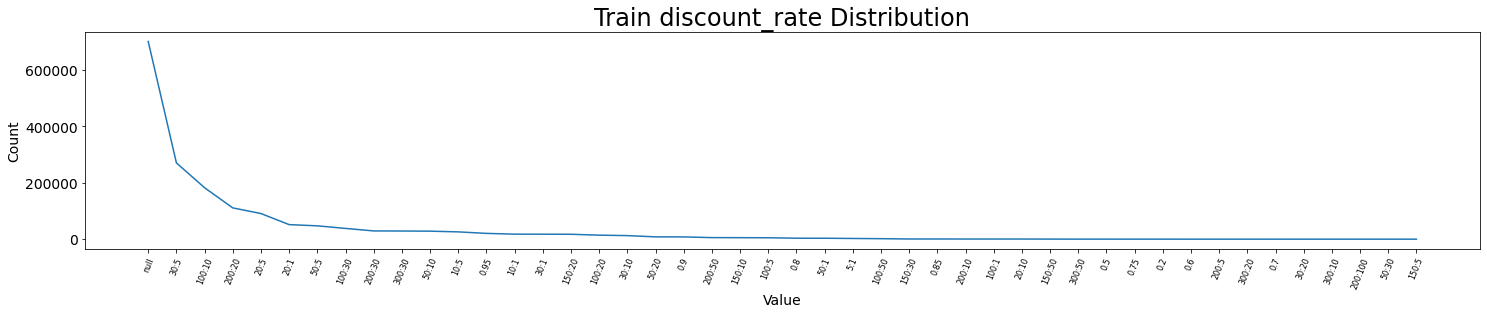

In [53]:
plt.rcParams['figure.figsize'] = (25, 4)
plt.title("Train discount_rate Distribution",fontsize=24)
plt.xlabel("Value",fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.xticks(rotation=68,fontsize=8)
plt.plot(off_train['discount_rate'].value_counts())
plt.show()

In [40]:
off_test['discount_rate'].value_counts()

30:5       59318
20:1       11273
50:10       7476
20:5        7026
200:20      5496
30:1        4016
10:1        3758
100:10      3706
50:5        2693
100:20      2327
0.95         991
0.9          827
0.8          735
150:5        495
100:5        467
30:10        407
10:5         346
50:1         339
200:30       258
150:20       248
100:30       229
150:30       181
5:1          171
300:30       136
200:50       124
20:10        114
50:20         97
100:50        97
150:50        92
150:10        61
30:20         32
200:10        26
300:50        19
200:5         18
100:1         14
0.5           10
300:20        10
200:100        3
0.6            1
500:30         1
0.85           1
0.7            1
Name: discount_rate, dtype: int64

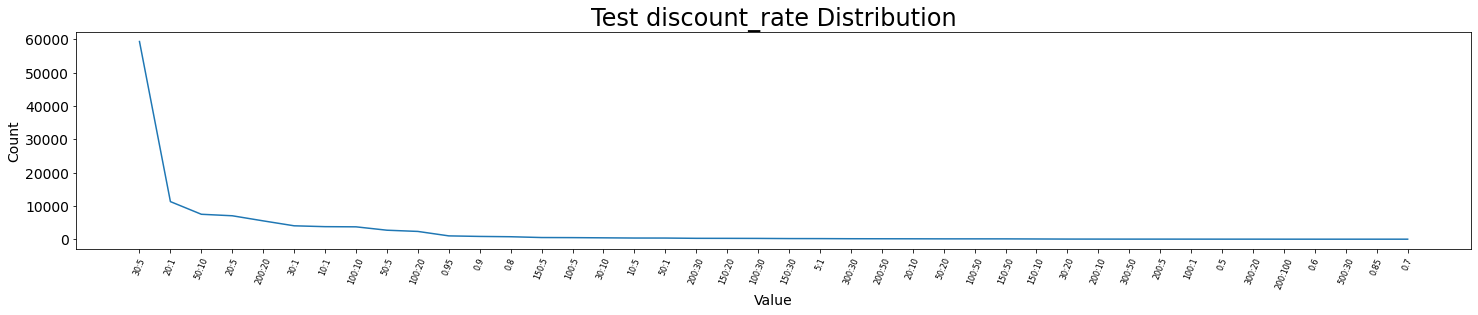

In [54]:
plt.rcParams['figure.figsize'] = (25, 4)
plt.title("Test discount_rate Distribution",fontsize=24)
plt.xlabel("Value",fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.xticks(rotation=68,fontsize=8)
plt.plot(off_test['discount_rate'].value_counts())
plt.show()

In [41]:
off_train['distance'].value_counts()

0       826070
1       227221
10      206484
2       118413
null    106003
3        76598
4        55085
5        41452
6        32483
7        25681
8        21436
9        17958
Name: distance, dtype: int64

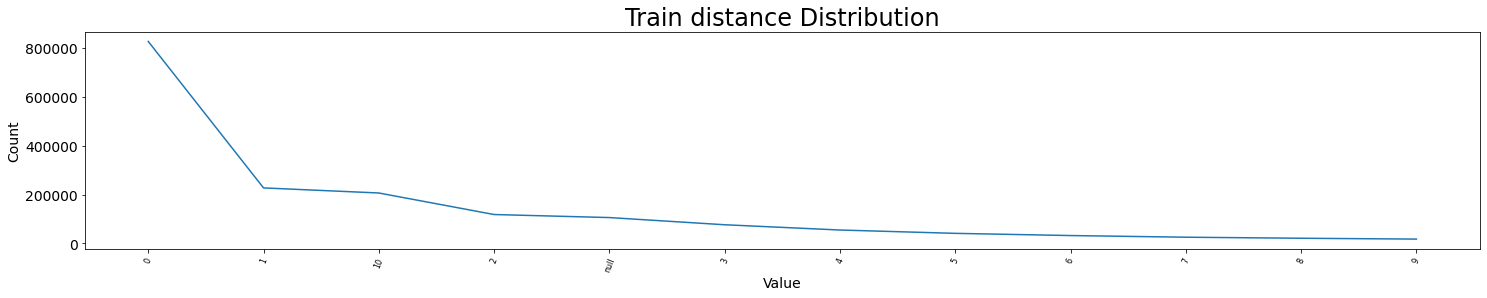

In [55]:
plt.rcParams['figure.figsize'] = (25, 4)
plt.title("Train distance Distribution",fontsize=24)
plt.xlabel("Value",fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.xticks(rotation=68,fontsize=8)
plt.plot(off_train['distance'].value_counts())
plt.show()

In [42]:
off_test['distance'].value_counts()

0       43867
1       18474
null    12064
10      10353
2        9523
3        5934
4        4006
5        2977
6        2179
7        1685
8        1359
9        1219
Name: distance, dtype: int64

通过初步观察感觉训练集和测试集数据分布比较一致。

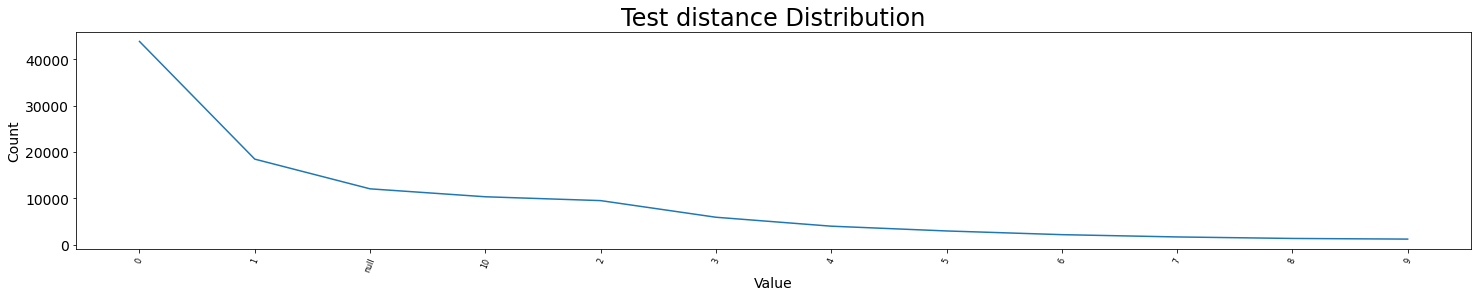

In [56]:
plt.rcParams['figure.figsize'] = (25, 4)
plt.title("Test distance Distribution",fontsize=24)
plt.xlabel("Value",fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.xticks(rotation=68,fontsize=8)
plt.plot(off_test['distance'].value_counts())
plt.show()

# 数据处理及分析

## 将特征数值化

In [21]:
#分隔符
separator=':'
#计算折扣率，将满减和折扣统一，因为discount_rate为null的时候一般都是没有使用优惠券，这个时候折扣应该是1
def get_discount_rate(s):
    s = str(s)
    if s=='null':
        # return -1
        return 1
    s = s.split(separator)
    if len(s) == 1:
        return float(s[0])
    else:
        return 1.0-float(s[1])/float(s[0])

#获取是否满减（full reduction promotion）
def get_if_fd(s):
    s = str(s)
    s = s.split(separator)
    if len(s)==1:
        return 0
    else:
        return 1
        
#获取满减的满值
def get_full_value(s):
    s = str(s)
    s = s.split(separator)
    if len(s)==1:
        return -1
    else:
        return int(s[0])
        
#获取满减的减值   
def get_reduction_value(s):
    s = str(s)
    s = s.split(separator)
    if len(s) == 1:
        return -1
    else:
        return int(s[1])


#获取月份
def get_month(s):
    if s[0]=='null':
        return -1
    else:    
        return int(s[4:6])

#获取日期
def get_day(s):
    if s[0]=='null':
        return -1
    else:    
        return int(s[6:8])

In [24]:
def add_feature(df):
    df['if_fd']=df['discount_rate'].apply(get_if_fd) # 获取是否有满减
    df['full_value']=df['discount_rate'].apply(get_full_value) #获取满减的满值
    df['reduction_value']=df['discount_rate'].apply(get_reduction_value) #获取满减的减值 
    df['discount_rate']=df['discount_rate'].apply(get_discount_rate)#计算折扣率，将满减和折扣统一
    
    df['distance']=df['distance'].replace('null',-1).astype(int)
    #df['month_received'] = df['date_received'].apply(get_month)
    #df['month'] = df['date'].apply(get_month)
    return df

In [25]:
#拷贝数据，免得调试的时候重读文件
dftrain = off_train.copy()
dftest = off_test.copy()

dftrain=add_feature(dftrain)
dftest=add_feature(dftest)

In [26]:
off_train.head()

,user_id,merchant_id,coupon_id,discount_rate,distance,date_received,date
0,1439408,2632,null,null,0,null,20160217
1,1439408,4663,11002,150:20,1,20160528,null
2,1439408,2632,8591,20:1,0,20160217,null
3,1439408,2632,1078,20:1,0,20160319,null
4,1439408,2632,8591,20:1,0,20160613,null


In [27]:
dftrain.head()

,user_id,merchant_id,coupon_id,discount_rate,distance,date_received,date,if_fd,full_value,reduction_value
0,1439408,2632,null,1.000000,0,null,20160217,0,-1,-1
1,1439408,4663,11002,0.866667,1,20160528,null,1,150,20
2,1439408,2632,8591,0.950000,0,20160217,null,1,20,1
3,1439408,2632,1078,0.950000,0,20160319,null,1,20,1
4,1439408,2632,8591,0.950000,0,20160613,null,1,20,1


In [28]:
#获取日期间隔输入内容为Date:Date_received
def get_day_gap(s):
    s = s.split(separator)
    if s[0]=='null':
        return -1
    if s[1]=='null':
        return -1
    else:    
        return (date(int(s[0][0:4]),int(s[0][4:6]),int(s[0][6:8])) - date(int(s[1][0:4]),int(s[1][4:6]),int(s[1][6:8]))).days

#获取Label，输入内容为Date:Date_received，小于15天返回1代表15天内用了优惠劵，否则返回-1代表没使用，0代表没有领取，检测目标就是预测15天内是否使用了优惠券
def get_label(s):
    s = s.split(separator)
    if s[0]=='null':
        return 0
    if s[1]=='null':
        return -1
    elif (date(int(s[0][0:4]),int(s[0][4:6]),int(s[0][6:8]))-date(int(s[1][0:4]),int(s[1][4:6]),int(s[1][6:8]))).days<=15:
        return 1
    else:
        return -1
    
def add_label(df):
    df['day_gap']=df['date'].astype('str') + ':' +  df['date_received'].astype('str')
    df['label']=df['day_gap'].apply(get_label)
    df['day_gap']=df['day_gap'].apply(get_day_gap)
    return df

In [29]:
dftrain=add_label(dftrain)
dftrain

,user_id,merchant_id,coupon_id,discount_rate,distance,date_received,date,if_fd,full_value,reduction_value,day_gap,label
0,1439408,2632,null,1.000000,0,null,20160217,0,-1,-1,-1,-1
1,1439408,4663,11002,0.866667,1,20160528,null,1,150,20,-1,0
2,1439408,2632,8591,0.950000,0,20160217,null,1,20,1,-1,0
3,1439408,2632,1078,0.950000,0,20160319,null,1,20,1,-1,0
4,1439408,2632,8591,0.950000,0,20160613,null,1,20,1,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1754879,212662,3532,null,1.000000,1,null,20160322,0,-1,-1,-1,-1
1754880,212662,3021,3739,0.966667,6,20160508,20160602,1,30,1,25,-1
1754881,212662,2934,null,1.000000,2,null,20160321,0,-1,-1,-1,-1
1754882,752472,7113,1633,0.800000,6,20160613,null,1,50,10,-1,0


## 数据分析

In [34]:
dftrain.select_dtypes(exclude=['object']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   discount_rate    float64
 1   distance         int32  
 2   if_fd            int64  
 3   full_value       int64  
 4   reduction_value  int64  
 5   day_gap          int64  
 6   label            int64  
dtypes: float64(1), int32(1), int64(5)
memory usage: 87.0 MB


In [31]:
dftrain.describe() # object类型的数据不会显示

,discount_rate,distance,if_fd,full_value,reduction_value,day_gap,label
count,1.754884e+06,1.754884e+06,1.754884e+06,1.754884e+06,1.754884e+06,1.754884e+06,1.754884e+06
mean,9.065689e-01,2.158577e+00,5.812407e-01,4.665974e+01,5.807668e+00,-6.212582e-01,-3.693657e-01
std,1.035167e-01,3.470772e+00,4.933559e-01,6.830349e+01,9.037305e+00,2.414021e+00,5.534657e-01
min,2.000000e-01,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,8.333333e-01,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
50%,9.000000e-01,0.000000e+00,1.000000e+00,2.000000e+01,5.000000e+00,-1.000000e+00,0.000000e+00
75%,1.000000e+00,3.000000e+00,1.000000e+00,1.000000e+02,1.000000e+01,-1.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+01,1.000000e+00,3.000000e+02,1.000000e+02,9.600000e+01,1.000000e+00


In [36]:
dftest.describe()

,discount_rate,distance,date_received,if_fd,full_value,reduction_value
count,113640.000000,113640.000000,1.136400e+05,113640.000000,113640.000000,113640.000000
mean,0.850671,1.974736,2.016072e+07,0.977420,43.396507,6.089141
std,0.063551,3.248809,9.019508e+00,0.148561,44.239815,5.640310
min,0.333333,-1.000000,2.016070e+07,0.000000,-1.000000,-1.000000
25%,0.833333,0.000000,2.016071e+07,1.000000,30.000000,5.000000
50%,0.833333,1.000000,2.016072e+07,1.000000,30.000000,5.000000
75%,0.900000,3.000000,2.016072e+07,1.000000,30.000000,5.000000
max,0.990000,10.000000,2.016073e+07,1.000000,500.000000,100.000000


<AxesSubplot:title={'center':'Train Distribution if have distance'}>

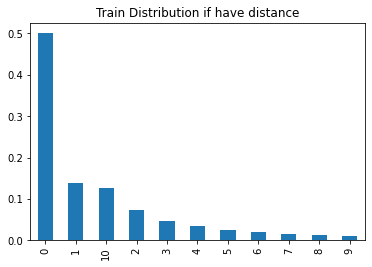

In [56]:
tf1 = dftrain[dftrain.distance>=0]['distance'].value_counts()/dftrain[dftrain.distance>=0]['distance'].count()
tf1.plot(kind='bar',title='Train Distribution if have distance')

<AxesSubplot:title={'center':'Test Distribution if have distance'}>

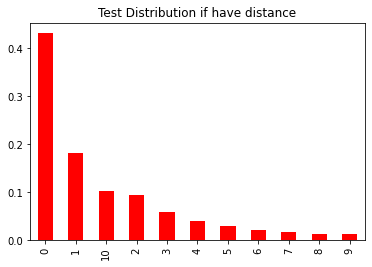

In [55]:
tf2 = dftest[dftest.distance>=0]['distance'].value_counts()/dftest[dftest.distance>=0]['distance'].count()
tf2.plot(kind='bar',color='red',title='Test Distribution if have distance')

In [57]:
yes = dftrain[(dftrain.label>=0)&(dftrain.distance>=0)] # 在15天内使用优惠卷 且 有客户离商户距离 的数据
yes.describe()

,discount_rate,distance,if_fd,full_value,reduction_value,day_gap,label
count,937174.000000,937174.000000,937174.000000,937174.000000,937174.000000,937174.000000,937174.000000
mean,0.843406,3.250696,0.971583,78.942083,10.374345,-0.621642,0.060885
std,0.089908,3.825817,0.166162,72.972902,9.123003,1.776970,0.239120
min,0.200000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,0.833333,0.000000,1.000000,30.000000,5.000000,-1.000000,0.000000
50%,0.850000,1.000000,1.000000,50.000000,5.000000,-1.000000,0.000000
75%,0.900000,6.000000,1.000000,100.000000,10.000000,-1.000000,0.000000
max,0.990000,10.000000,1.000000,300.000000,100.000000,15.000000,1.000000


<AxesSubplot:title={'center':'Train distribution if in 15 days used coupon and have distance'}>

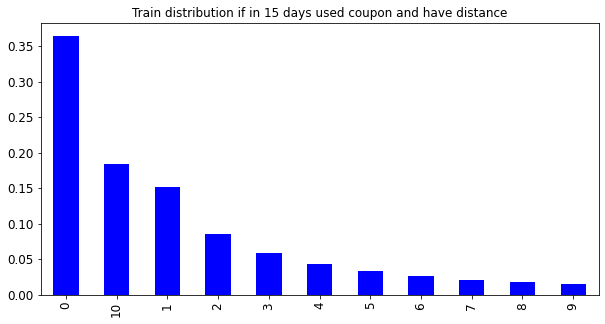

In [58]:
tf3 = yes['distance'].value_counts() / yes['distance'].count()
tf3.plot(kind='bar',color='blue',figsize=(10,5),fontsize=12,title='Train distribution if in 15 days used coupon and have distance')

In [38]:
print ('线下 训练集满减情况')
dftrain.if_fd.value_counts()/dftrain.if_fd.count()

线下 训练集满减情况


1    0.581241
0    0.418759
Name: if_fd, dtype: float64

In [39]:
print ('测试集满减情况')
dftest.if_fd.value_counts()/dftest.if_fd.count()

测试集满减情况


1    0.97742
0    0.02258
Name: if_fd, dtype: float64

## 箱线图查看分布

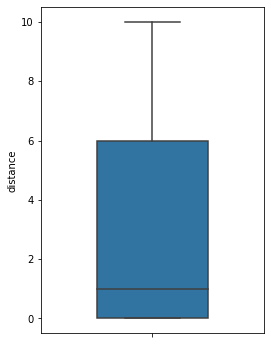

In [61]:
fig = plt.figure(figsize=(4, 6))  # 指定绘图对象宽度和高度
sns.boxplot(y=dftrain[(dftrain.label >= 0) & (dftrain.distance >= 0)]['distance'], orient="v", width=0.5)
plt.show()

- 中位数（Median）：中位数大约在1左右，表示一半的数据点的距离低于这个值，另一半高于这个值。
- 四分位数（Quartiles）：
    - 第一四分位数（Q1）：大约在0左右，表示25%的数据点的距离低于这个值。
    - 第三四分位数（Q3）：大约在6左右，表示75%的数据点的距离低于这个值。
- 四分位距（Interquartile Range, IQR）：IQR（Q3-Q1）大约是6，表示数据中间50%的范围。
- 须（Whiskers）：上须大约延伸到10，下须大约延伸到0。
- 数据范围：距离的最小值大约在0左右，最大值大约在10左右。
- 集中趋势：距离的中位数和四分位数都集中在0.5到6之间，表示大多数距离在这个范围内。

<AxesSubplot:ylabel='discount_rate'>

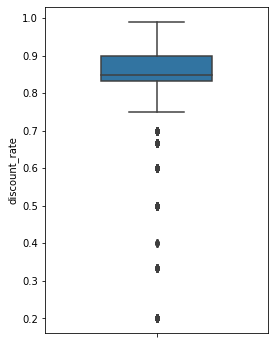

In [63]:
fig = plt.figure(figsize=(4, 6))  # 指定绘图对象宽度和高度
sns.boxplot(y=dftrain[(dftrain.label>=0)&(dftrain.discount_rate>=0)]['discount_rate'],orient="v", width=0.5)

从这个箱型图中可以得到以下信息：

- 中位数（Median）：折扣率的中位数大约在0.85左右，表示一半的数据点的折扣率低于这个值，另一半高于这个值。
- 四分位数（Quartiles）：
    - 第一四分位数（Q1）：大约在0.8左右，表示25%的数据点的折扣率低于这个值。
    - 第三四分位数（Q3）：大约在0.9左右，表示75%的数据点的折扣率低于这个值。
- 四分位距（Interquartile Range, IQR）：IQR（Q3-Q1）大约是0.1，表示数据中间50%的范围。
- 须（Whiskers）：须的长度表示数据的范围，除了异常值之外，大部分数据都位于这个范围内。上须大约延伸到0.95，下须大约延伸到0.75。
- 异常值（Outliers）：图中有一些点位于须之外，被认为是异常值或离群点。这些点的折扣率明显低于其他数据点，可能是由于错误或真实的变异性。
- 数据分布：折扣率的分布大致对称，但有一些异常值拉低了下须。
- 数据范围：折扣率的最小值大约在0.2左右，最大值大约在1.0左右。
- 集中趋势：折扣率的中位数和四分位数都集中在0.8到0.9之间，表示大多数折扣率在这个范围内。

## 直方图和QQ图

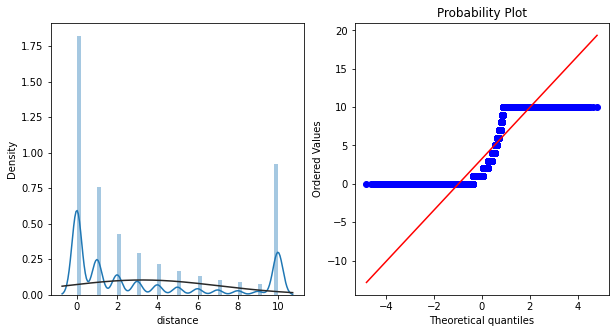

In [64]:
plt.figure(figsize=(10,5))

ax=plt.subplot(1,2,1)
sns.distplot(dftrain[(dftrain.label>=0)&(dftrain.distance>=0)]['distance'],fit=stats.norm)
ax=plt.subplot(1,2,2)
res = stats.probplot(dftrain[(dftrain.label>=0)&(dftrain.distance>=0)]['distance'], plot=plt)

- 左图：核密度估计图（Kernel Density Estimate, KDE）
    - 分布形态：图中显示了distance变量的核密度估计，这是一种非参数方式来估计数据的概率密度函数。图中显示了多个尖峰，表明数据可能不是单一正态分布，可能意味着数据存在异常值。
    - 数据集中：大部分数据集中在0到10之间，但分布并不均匀，存在多个局部峰值。
- 右图：正态概率图（Normal Probability Plot）
    - 正态性检验：右图是一个正态概率图，用于检验数据是否符合正态分布。图中的点表示实际数据的分位数，红线表示理论上的正态分布分位数。
    - 偏离直线：如果数据点大致沿着一条直线分布，那么可以认为数据近似正态分布。然而，从图中可以看到，数据点在两端明显偏离了直线，特别是在尾部，这表明数据可能不是正态分布的。
    - 尾部偏离：数据在两端的偏离尤为明显，这可能意味着数据存在重尾现象，即极端值（异常值）比正态分布预期的要多。
- 总结
    - 分布特征：distance变量的分布不是单一的正态分布，而是存在多个峰值，可能需要进一步分析这些峰值的原因。
    - 正态性检验：正态概率图显示数据明显偏离正态分布，特别是在尾部，这可能影响使用正态分布假设的统计方法的适用性。


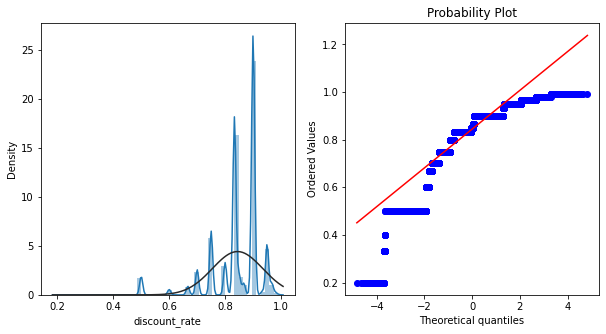

In [65]:
plt.figure(figsize=(10,5))

ax=plt.subplot(1,2,1)
sns.distplot(dftrain[(dftrain.label>=0)&(dftrain.discount_rate>=0)]['discount_rate'],fit=stats.norm)
ax=plt.subplot(1,2,2)
res = stats.probplot(dftrain[(dftrain.label>=0)&(dftrain.discount_rate>=0)]['discount_rate'], plot=plt)

## 对比分布

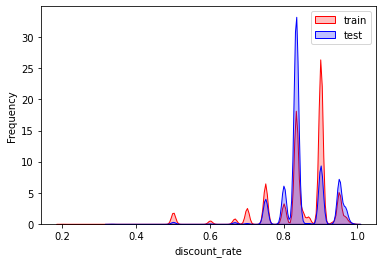

In [66]:
ax = sns.kdeplot(dftrain[(dftrain.label>=0)&(dftrain.discount_rate>=0)]['discount_rate'], color="Red", shade=True)
ax = sns.kdeplot(dftest[(dftest.discount_rate>=0)]['discount_rate'], color="Blue", shade=True)
ax.set_xlabel('discount_rate')
ax.set_ylabel("Frequency")
ax = ax.legend(["train","test"])

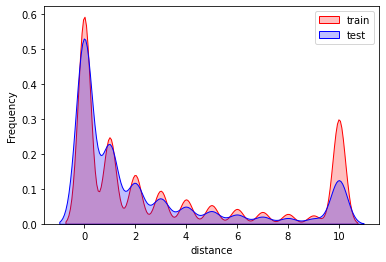

In [67]:
ax = sns.kdeplot(dftrain[(dftrain.label>=0)&(dftrain.distance>=0)]['distance'], color="Red", shade=True)
ax = sns.kdeplot(dftest[(dftest.distance>=0)]['distance'], color="Blue", shade=True)
ax.set_xlabel('distance')
ax.set_ylabel("Frequency")
ax = ax.legend(["train","test"])

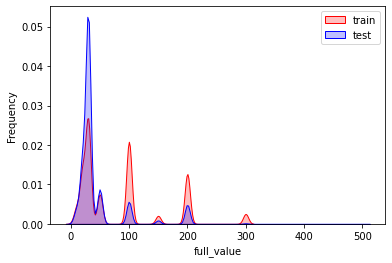

In [68]:
ax = sns.kdeplot(dftrain[(dftrain.label>=0)&(dftrain.full_value>=0)]['full_value'], color="Red", shade=True)
ax = sns.kdeplot(dftest[(dftest.full_value>=0)]['full_value'], color="Blue", shade=True)
ax.set_xlabel('full_value')
ax.set_ylabel("Frequency")
ax = ax.legend(["train","test"])

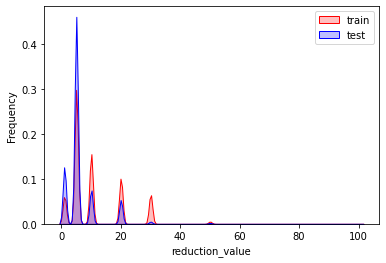

In [69]:
ax = sns.kdeplot(dftrain[(dftrain.label>=0)&(dftrain.reduction_value>=0)]['reduction_value'], color="Red", shade=True)
ax = sns.kdeplot(dftest[(dftest.reduction_value>=0)]['reduction_value'], color="Blue", shade=True)
ax.set_xlabel('reduction_value')
ax.set_ylabel("Frequency")
ax = ax.legend(["train","test"])

## 可视化线性关系

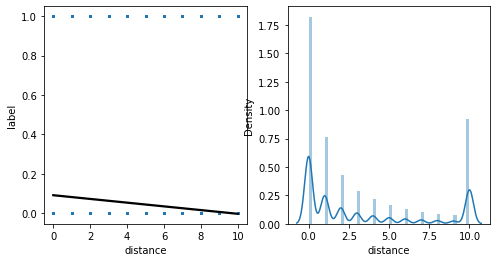

In [70]:
fcols = 2
frows = 1
plt.figure(figsize=(8,4))
ax=plt.subplot(1,2,1)
sns.regplot(x='distance', y='label', data=dftrain[(dftrain.label>=0)&(dftrain.distance>=0)][['distance','label']], ax=ax, 
            scatter_kws={'marker':'.','s':3,'alpha':0.3},
            line_kws={'color':'k'});
plt.xlabel('distance')
plt.ylabel('label')

ax=plt.subplot(1,2,2)
sns.distplot(dftrain[(dftrain.label>=0)&(dftrain.distance>=0)]['distance'].dropna())
plt.xlabel('distance')
plt.show()

 左图：回归图（Regression Plot）

1. **散点图与回归线**：
   - 图中展示了`distance`与`label`之间的关系，使用散点图表示数据点，并用回归线表示两者之间的趋势。
   - 散点图中的点使用了`'.'`作为标记，点的大小为3，透明度为0.3，这有助于在数据点密集时更好地观察数据分布。
2. **趋势分析**：
   - 回归线显示了`distance`与`label`之间的负相关关系，即随着距离的增加，客户15天内使用优惠卷呈现下降趋势。
   - 这种趋势可能表明，随着距离的增加客户15天内使用优惠卷的可能性降低。

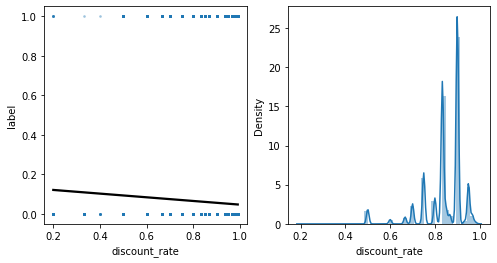

In [71]:
fcols = 2
frows = 1
plt.figure(figsize=(8,4))
ax=plt.subplot(1,2,1)
sns.regplot(x='discount_rate', y='label', data=dftrain[(dftrain.label>=0)&(dftrain.discount_rate>=0)][['discount_rate','label']], ax=ax, 
            scatter_kws={'marker':'.','s':3,'alpha':0.3},
            line_kws={'color':'k'});
plt.xlabel('discount_rate')
plt.ylabel('label')

ax=plt.subplot(1,2,2)
sns.distplot(dftrain[(dftrain.label>=0)&(dftrain.discount_rate>=0)]['discount_rate'].dropna())
plt.xlabel('discount_rate')
plt.show()